# DEEP CROSSENTROPY METHOD

### MountainCar-v0

#### Setting up environment:

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The dimensionality of observation space is  2
The number of actions available to the agent is  3


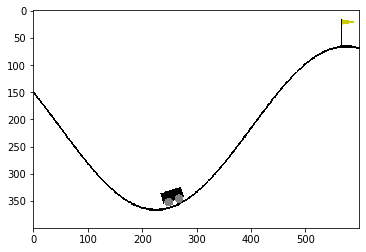

In [2]:
env = gym.make('MountainCar-v0').env

env.reset()

state_dims = env.observation_space.shape[0]
n_actions = env.action_space.n

print('The dimensionality of observation space is ', state_dims)
print('The number of actions available to the agent is ', n_actions)
plt.imshow(env.render('rgb_array'))

#### Test:

In [3]:
# Randomly sampled actions
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

#### Initiating Neural Network Policy:

In [4]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(10, 20, 20, 10),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

C:\Users\zhivk\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Session generator:

In [5]:
def generate_session(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max): 
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = np.reshape(agent.predict_proba([s]), -1)

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(range(len(probs)), p = probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # Recording sessions
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.51135294  0.        ]
 [-0.51044476  0.00090818]
 [-0.50963521  0.00080955]
 [-0.50793036  0.00170485]
 [-0.50534298  0.00258738]]
actions: [2, 1, 2, 2, 1]
reward: -5.0


#### Crossentropy method:

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, alpha = 0.5, percentile = 50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    
    elite_state = []
    elite_action = []
    
    # Finding the reward threshold:
    reward_threshold = alpha*np.percentile(rewards_batch, percentile) + (1-alpha)*np.mean(rewards_batch)
    
    # Looping over the sessions to select the ones with total reward higher than the threshold:
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold: 
            elite_state.append(states_batch[i])
            elite_action.append(actions_batch[i])
            
            
    # Flattening the list of elite states and actions:
    elite_states = [item for sublist in elite_state for item in sublist]        
    elite_actions = [item for sublist in elite_action for item in sublist]
        
    return elite_states, elite_actions

#### Training loop:

In [8]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = -136.740, threshold=-118.900


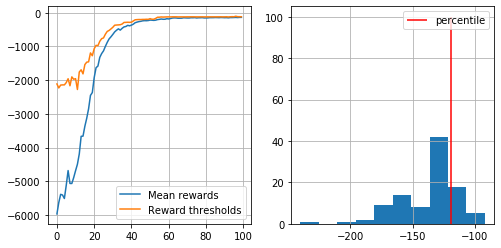

In [9]:
n_sessions = 100
percentile = 90
log = []

for i in range(100):
    # generate new sessions
    sessions = [ generate_session(agent, t_max = 10000) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, (1 - i/100), percentile)

    #<partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, elite_actions)
    
    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")